<a href="https://colab.research.google.com/github/mjmousavi97/Deep-Learning-Tehran-uni/blob/main/HomeWorks/06%20HW/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from sklearn.metrics import accuracy_score, f1_score, precision_score

import warnings
import zipfile
warnings.filterwarnings('ignore')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),

    # transform to adding noise
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1),

    transforms.RandomRotation((-20, 20)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In this code, we first use datasets.ImageFolder to create a PyTorch Dataset from images stored in a directory. The directory should be structured such that each class has its own subfolder, for example: data/class0/, data/class1/, etc., where the images of each class are stored. The transform argument applies a series of preprocessing and augmentation operations to each image, such as resizing, normalization, rotation, or adding noise. Each element of the resulting dataset is a tuple (image, label), where image is a tensor of shape [C, H, W] after transformation, and label is an integer representing the class of the image.

Next, the dataset is split into training, validation, and test subsets using random_split. This function takes the dataset and a list specifying the number of samples for each subset. It returns three separate Dataset objects, each behaving like the original dataset but containing only the assigned number of samples. It is important that the sum of the subset sizes equals the total number of samples in the dataset to avoid errors.

After splitting, we use DataLoader to create iterators for each subset. A DataLoader takes a Dataset and returns batches of data that can be fed directly into a neural network. Important parameters include batch_size, which defines how many samples are in each batch, shuffle, which if set to True randomizes the order of samples at each epoch (recommended for the training set), and num_workers, which specifies how many subprocesses are used to load the data in parallel for faster performance. Each iteration over a DataLoader yields a tuple (inputs, labels), where inputs is a tensor of shape [batch_size, C, H, W] representing a batch of images, and labels is a tensor of shape [batch_size] containing the corresponding class labels.

In [1]:
from google.colab import files
files.upload()

Saving CT_COVID.zip to CT_COVID.zip
Saving CT_NonCOVID.zip to CT_NonCOVID.zip


In [4]:
with zipfile.ZipFile('CT_NonCOVID.zip', 'r') as non_coviid_zip:
    non_coviid_zip.extractall('/content/data')

In [5]:
with zipfile.ZipFile('CT_COVID.zip', 'r') as covid_zip:
    covid_zip.extractall('/content/data')

In [6]:
import shutil

path = '/content/data/__MACOSX'
shutil.rmtree(path)

In [7]:
dataset = datasets.ImageFolder(root='./data', transform=transform)

train_size = int(0.6 * len(dataset))
remaining = len(dataset) - train_size
val_size = remaining // 2
test_size = remaining - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


In [15]:
class bottleneck(nn.Module):
    """
    Bottleneck block used in ResNet-50/101/152.

    This block has three convolutional layers:
      1. 1x1 conv to reduce channels.
      2. 3x3 conv for spatial processing.
      3. 1x1 conv to expand channels by the expansion factor (default 4).

    A residual (shortcut) connection is added from input to output.
    If the input and output shapes don't match, a `downsample` layer can
    be provided to adjust them.

    :Parameters:

    in_channels : int
        Number of channels in the input.
    out_channels : int
        Number of channels in the bottleneck layers. Output will be out_channels * 4.
    stride : int, optional
        Stride for the 3x3 conv. Defaults to 1.
    downsample : nn.Module or None, optional
        Layer to match the input to output shape if needed.

    :Notes:

    Use downsample when stride > 1 or the number of channels changes.
    """

    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.stride = stride
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels*self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)


    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [16]:
import torch
import torch.nn as nn

class ResNet(nn.Module):
    """
    Residual Network (ResNet) implementation.

    This class defines the ResNet backbone, composed of an initial convolution
    stem, followed by a series of residual blocks (Bottlenecks), global average
    pooling, and a fully connected classifier.

    :Parameters:

    block : nn.Module
        Residual block type to be used (e.g., Bottleneck).
    layers : list of int
        Number of blocks in each of the four main layers.
    in_channels : int, optional
        Number of input channels to the first convolutional layer (default: 64).
    num_classes : int, optional
        Number of output classes for the final classification layer (default: 1000).

    :Attributes:

    conv1 : nn.Conv2d
        Initial convolution layer.
    bn1 : nn.BatchNorm2d
        Batch normalization after the first convolution.
    relu : nn.ReLU
        ReLU activation function.
    maxpool : nn.MaxPool2d
        Max pooling layer after the initial stem.
    layer1-4 : nn.Sequential
        Stacked residual layers with different channel sizes.
    avgpool : nn.AdaptiveAvgPool2d
        Global average pooling to reduce spatial dimensions to (1,1).
    fc : nn.Linear
        Fully connected layer mapping features to class scores.
    """

    def __init__(self, block, layers, in_channels=64, num_classes=1000):
        super().__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes

        # Initial convolution + BN + ReLU + MaxPool (the "stem" of the network)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.in_channels,
                               kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers with different output channel sizes
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Global average pooling + fully connected classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, self.num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        """
        Build one stage of the ResNet with stacked residual blocks.

        :Parameters:

        block : nn.Module
            Residual block type to use.
        out_channels : int
            Number of output channels for the blocks in this layer.
        blocks : int
            Number of residual blocks to stack.
        stride : int, optional
            Stride for the first block in the layer (default: 1).

        :Returns:

        nn.Sequential
            A sequential container of residual blocks.
        """
        downsample = None

        # If dimensions change (due to stride or expansion), add a downsampling layer
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        # First block may need downsampling
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        # Remaining blocks keep the same dimensions
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the ResNet model.

        :Parameters:

        x : torch.Tensor
            Input tensor of shape [batch_size, 3, H, W].

        :Returns:

        torch.Tensor
            Output tensor of shape [batch_size, num_classes].
        """
        # Initial convolutional stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Global pooling + flatten + classifier
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # flatten to [batch_size, features]
        x = self.fc(x)

        return x


In [17]:
def train_and_validation(model, train_loader, val_loader, epochs, optimizer, criterion, device):
    """
    Train and validate a PyTorch model.

    This function performs training and validation for a given model over a specified number of epochs.
    During training, it updates the model parameters using the optimizer and computes the loss and accuracy.
    During validation, it evaluates the model without updating weights and computes metrics such as
    precision, F1 score, and overall accuracy.

    :param model: torch.nn.Module
        The neural network model to be trained and evaluated.
    :param train_loader: DataLoader
        PyTorch DataLoader for the training dataset.
    :param val_loader: DataLoader
        PyTorch DataLoader for the validation dataset.
    :param epochs: int
        Number of epochs to train the model.
    :param optimizer: torch.optim.Optimizer
        Optimizer used for updating model parameters.
    :param criterion: torch.nn.modules.loss._Loss
        Loss function used to compute the training and validation loss.
    :param device: torch.device
        Device to perform computations on (CPU or CUDA).

    :returns: tuple of lists
        train_loss_history, val_loss_history, train_acc_history, val_acc_history
        Lists containing the loss and accuracy values for each epoch.
    """

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()  # set model to training mode
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()       # reset gradients
            outputs = model(inputs)     # forward pass
            loss = criterion(outputs, labels)
            loss.backward()             # compute gradients
            optimizer.step()            # update weights

            running_loss += loss.item()  # accumulate batch loss
            _, preds = torch.max(outputs, 1)  # predicted classes
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        model.eval()  # set model to evaluation mode
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total = 0

        all_preds = []
        all_labels = []

        with torch.no_grad():  # disable gradient computation
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                val_running_loss += val_loss.item()
                _, val_preds = torch.max(val_outputs, 1)
                val_running_corrects += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

                all_preds.extend(val_preds.cpu().numpy())
                all_labels.extend(val_labels.cpu().numpy())

        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = val_running_corrects / val_total

        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f} - "
              f"Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f}")

        precision = precision_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)

        print(f"Precision: {precision:.4f} - F1 Score: {f1:.4f} - Accuracy: {accuracy:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [20]:
Resnet_model = ResNet(block=bottleneck, layers=[3, 4, 6, 3], num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Resnet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(Resnet_model.parameters(), lr=0.0001)

train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_and_validation(Resnet_model, train_loader, val_loader, epochs=100, optimizer=optimizer, criterion=criterion, device=device)

Epoch 1/100 - Train Loss: 0.7167 - Train Acc: 0.5928 - Val Loss: 0.6918 - Val Acc: 0.5973
Precision: 0.3568 - F1 Score: 0.4467 - Accuracy: 0.5973
Epoch 2/100 - Train Loss: 0.6002 - Train Acc: 0.6957 - Val Loss: 0.9634 - Val Acc: 0.5973
Precision: 0.3568 - F1 Score: 0.4467 - Accuracy: 0.5973
Epoch 3/100 - Train Loss: 0.6038 - Train Acc: 0.6935 - Val Loss: 1.5672 - Val Acc: 0.5973
Precision: 0.3568 - F1 Score: 0.4467 - Accuracy: 0.5973
Epoch 4/100 - Train Loss: 0.5643 - Train Acc: 0.7494 - Val Loss: 1.3578 - Val Acc: 0.5973
Precision: 0.3568 - F1 Score: 0.4467 - Accuracy: 0.5973
Epoch 5/100 - Train Loss: 0.5350 - Train Acc: 0.7517 - Val Loss: 1.2063 - Val Acc: 0.5973
Precision: 0.3568 - F1 Score: 0.4467 - Accuracy: 0.5973
Epoch 6/100 - Train Loss: 0.5650 - Train Acc: 0.7047 - Val Loss: 0.6829 - Val Acc: 0.5973
Precision: 0.3568 - F1 Score: 0.4467 - Accuracy: 0.5973
Epoch 7/100 - Train Loss: 0.5719 - Train Acc: 0.7293 - Val Loss: 0.6065 - Val Acc: 0.6779
Precision: 0.6875 - F1 Score: 0.64

In [21]:
torch.save(Resnet_model.state_dict(), 'Resnet_model')

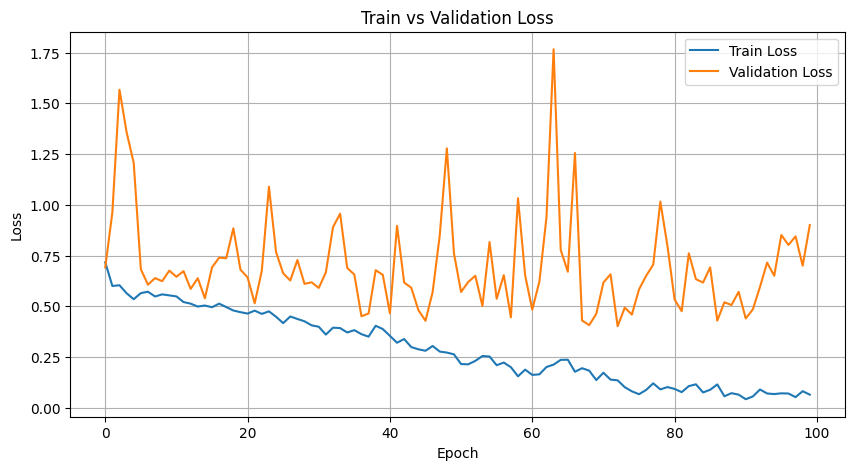

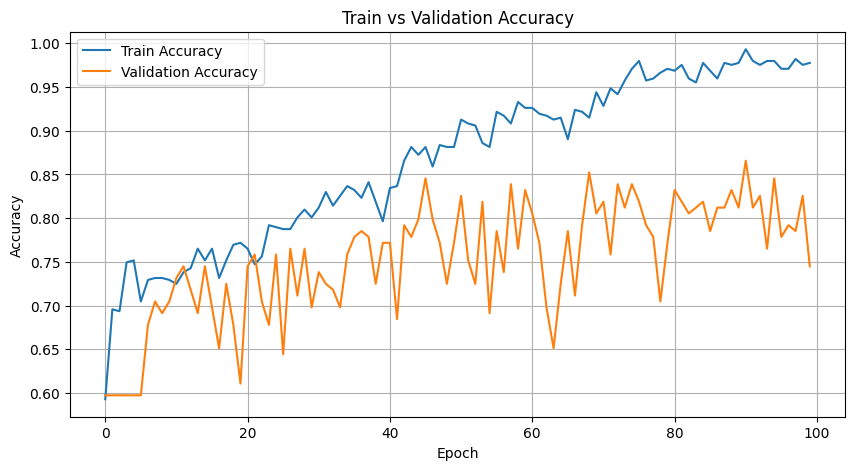

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# رسم Accuracy
plt.figure(figsize=(10,5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()